In [1]:
from pytorch_lightning import callbacks
import yaml
import argparse
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from models import *
from experiments.vae_experiment import VAEXperiment
from experiments.feature_experiment import Pix2pixExperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TestTubeLogger
from torch.utils.data import DataLoader 
from terrain_loader import TerrainDataset
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:

with open("configs/feature_gan.yml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(".\n\n",exc)

In [3]:
dataset = TerrainDataset(root = config['exp_params']['data_path'],
                        train=False,
                        hide_green=config['exp_params']['hide_green'],
                        norm=config['exp_params']['norm'])

sample_dataloader = DataLoader(dataset,
                        batch_size= 1,
                        num_workers=config['exp_params']['n_workers'],
                        shuffle = True,
                        drop_last=False)

In [4]:
# VAE-FeatureGAN 1
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VanillaVAE/version_0  /scratch/shan/
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VAE_PIX2PIX/version_33 /scratch/shan

In [5]:
# # VAE-FeatureGAN 2
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VanillaVAE/version_0  /scratch/shan/
# ! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VAE_PIX2PIX/version_40 /scratch/shan

receiving incremental file list
receiving incremental file list
version_40/
version_40/ReadMe.txt
             94 100%   91.80kB/s    0:00:00 (xfr#1, to-chk=13/15)
version_40/meta.experiment
            270 100%  263.67kB/s    0:00:00 (xfr#2, to-chk=12/15)
version_40/meta_tags.csv
             10 100%    9.77kB/s    0:00:00 (xfr#3, to-chk=11/15)
version_40/metrics.csv
      8,074,915 100%   89.54MB/s    0:00:00 (xfr#4, to-chk=10/15)
version_40/real_img_FEATURE_GAN_0.png
        517,964 100%    5.49MB/s    0:00:00 (xfr#5, to-chk=9/15)
version_40/recons_FEATURE_GAN_496.png
      1,326,591 100%   12.40MB/s    0:00:00 (xfr#6, to-chk=8/15)
version_40/recons_FEATURE_GAN_497.png
      1,358,783 100%   11.47MB/s    0:00:00 (xfr#7, to-chk=7/15)
version_40/recons_FEATURE_GAN_498.png
      1,328,455 100%   10.22MB/s    0:00:00 (xfr#8, to-chk=6/15)
version_40/recons_FEATURE_GAN_499.png
      1,331,392 100%    9.34MB/s    0:00:00 (xfr#9, to-chk=5/15)
version_40/checkpoints/
version_40/checkpoints/e

In [6]:
# # VAE-FeatureGAN 3
! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VanillaVAE/version_0  /scratch/shan/
! rsync -aP ada:/share3/shanthika_naik/pytorch_terrain_authoring/TerrainAuthoring_Pytorch/logs/VAE_PIX2PIX/version_40 /scratch/shan

In [7]:
#Vae Model
vae_model = vae_models[config['vae_model_params']['name']](**config['vae_model_params'])

# pix2pix model
gen_model = pix2pix_model[config['pix2pix_model_params']['gen_name']](config['exp_params']['in_channels'],config['exp_params']['out_channels'])
disc_model = pix2pix_model[config['pix2pix_model_params']['disc_name']](config['exp_params']['in_channels'])


In [8]:
if config['vae_model_params']['load_model'] :
    experiment_p2p = Pix2pixExperiment.load_from_checkpoint(config['pix2pix_model_params']['pretrained_model'], gen_model=gen_model,disc_model=disc_model,vae_model=vae_model,params=config['exp_params'])
    experiment_vae = VAEXperiment.load_from_checkpoint(config['vae_model_params']['pretrained_model'], vae_model=vae_model,params=config['exp_params'])
    print("[INFO] Loaded pretrained model")

[INFO] Loaded pretrained model


In [9]:
vae_model.eval()
gen_model.eval()

Generator(
  (decoder_input): Linear(in_features=128, out_features=16384, bias=True)
  (final_layer): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (dec1): UpSampleVAE(
    (model): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (dec2): UpSampleVAE(
    (model): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [10]:
def denormalize(result):
        # minv, maxv = torch.min(result), torch.max(result)
        new = (result+1)*127.5
        return torch.squeeze(new).detach().numpy().transpose((1,2,0)).astype(np.uint8)


In [11]:
def display(ip, op, val=0):
    res= vae_model(ip)[2] 
    
    res,vae_res = gen_model(res)
    vae_res = torch.squeeze(vae_res*255).detach().numpy().transpose((1,2,0)).astype(np.uint8)
      
    res = denormalize(res)
    op = denormalize(op)
    # ip = denormalize(ip)
    ip = (ip*255)
    ip = torch.squeeze(ip).detach().numpy().transpose((1,2,0)).astype(np.uint8)
    res = cv2.GaussianBlur(res, (5, 5), 0)
    
    print(ip.shape, op.shape,res.shape,vae_res.shape)
    ip = cv2.cvtColor(ip, cv2.COLOR_RGB2BGR)

    display_list = [ip,vae_res,res,op]
    title = ['Input image','VAE Output','Predicted_image','Ground_Truth']
    plt.figure(figsize=(15,15))

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i],cmap='gray')
        plt.axis('off')
        cv2.imwrite("disp_"+str(val)+"_"+str(i+1)+".png",display_list[i])
    plt.show()



(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


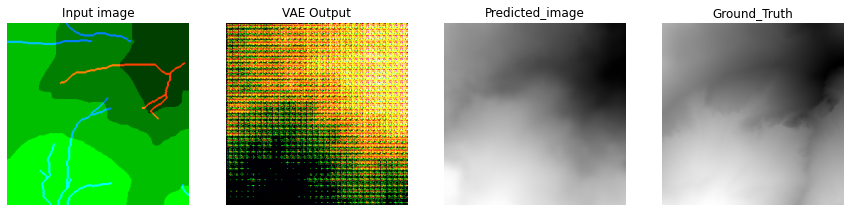

In [26]:
for ip, op in sample_dataloader:
    display(ip,op)
    
    break

In [13]:
def get_mse(ip,op ):
    res = vae_model(ip)[2] 
    res,_ = gen_model(res) 
    # print(op.shape, res.shape,op.type(),res.type())
    
    mse = np.mean((res.detach().numpy()-op.detach().numpy())**2)
    return mse

In [14]:
def calculate_mse( ):
    count=0
    mse_loss = 0 
    for ip, op in sample_dataloader:
        count+=1
        ml = get_mse(ip,op )  
        mse_loss += ml
    
    return mse_loss

In [15]:
print("MSE loss: ",calculate_mse())

MSE loss:  10.481841861386783
